In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
import statsmodels.api as sm

In [2]:
X_train = pd.read_csv('data/Training_set_values.csv', index_col='id')
X_test = pd.read_csv('data/Test_set_values.csv', index_col='id')
y_train = pd.read_csv('data/Training_set_labels.csv', index_col='id')

In [3]:
X_train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
y_train.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


## merging the X and y train data

In [5]:
df = X_train.merge(y_train, on='id')

>we merged the X train and y train data to build a dataframe that we could use to testing our different models on. The data set from where the data came did not have a y test dataset. We will split the merged dataset and create a hold out group later.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

# data cleaning

### feature engineering

>converting some categorical features represented as strings from our initial dataset into ternary values to be able to build additional features

In [7]:
tern_water_quality = {'soft':0,
                      'salty':1,
                      'unknown': 2,
                      'milky': 3,
                      'coloured':4,
                      'salty abandoned': 5, 
                      'fluoride': 6,
                      'fluoride abandoned': 7
}

tern_region = {'Iringa':0,
               'Shinyanga':1,
               'Mbeya':2,
               'Kilimanjaro':3,
               'Morogoro':4,
               'Arusha':5,
               'Kagera':6,
               'Mwanza':7,
               'Kigoma':8,
               'Ruvuma':9,
               'Pwani':10,
               'Tanga':11,
               'Dodoma':12,
               'Singida':13,
               'Mara':14,
               'Tabora':15,
               'Rukwa':16,
               'Mtwara':17,
               'Manyara':18,
               'Lindi':19,
               'Dar es Salaam':20                                     
}

tern_extraction_type = {'gravity':0,
                        'nira/tanira':1,
                        'other':2,
                        'submersible':3,
                        'swn 80':4,
                        'mono':5,
                        'india mark ii':6,
                        'afridev':7,
                        'ksb':8,
                        'other - rope pump':9,
                        'other - swn 81':10,
                        'windmill':11,
                        'india mark iii':12,
                        'cemo':13,
                        'other - play pump':14,
                        'walimi':15,
                        'climax':16,
                        'other - mkulima/shinyanga':17
}

tern_waterpoint_type = {'communal standpipe':0,
'hand pump':1,
'other':2,
'communal standpipe multiple':3,
'improved spring':4,
'cattle trough':5,
'dam':6
}

tern_source = { 'spring':0,
                'shallow well':1,
                'machine dbh':2,
                'river':3,
                'rainwater harvesting':4,
                'hand dtw':5,
                'lake':6,
                'dam':7,
                'other':8,
                'unknown':9
}

tern_scheme_management = {'VWC':0,
                          'WUG':1,
                          'Water authority':2,
                          'WUA':3,
                          'Water Board':4,
                          'Parastatal':5,
                          'Private operator':6,
                          'Company':7,
                          'Other':8,
                          'SWC':9,
                          'Trust':10,
                          'None':11
}

### creating some additional features as bivariate combinations which could be impactful for our modelling process


In [8]:
df.water_quality = [tern_water_quality[x] for x in df.water_quality]

In [9]:
df.region = [tern_region[x] for x in df.region]

In [10]:
df.waterpoint_type = [tern_waterpoint_type[x] for x in df.waterpoint_type]

In [11]:
df.source = [tern_source[x] for x in df.source]

### adding these new features to our dataframe

In [12]:
df['water_quality_by_region'] = df.water_quality * df.region
# df['water_quality_by_extraction_type'] = df.water_quality * df.extraction_type
df['water_quality_by_waterpoint_type'] = df.water_quality * df.waterpoint_type
df['water_quality_by_source'] = df.water_quality * df.source
# df['water_quality_by_scheme_management'] = df.water_quality * df.scheme_management
# df['water_quality_by_permit'] = df.water_quality * df.permit

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   amount_tsh                        59400 non-null  float64
 1   date_recorded                     59400 non-null  object 
 2   funder                            55765 non-null  object 
 3   gps_height                        59400 non-null  int64  
 4   installer                         55745 non-null  object 
 5   longitude                         59400 non-null  float64
 6   latitude                          59400 non-null  float64
 7   wpt_name                          59400 non-null  object 
 8   num_private                       59400 non-null  int64  
 9   basin                             59400 non-null  object 
 10  subvillage                        59029 non-null  object 
 11  region                            59400 non-null  int64  
 12  

# inferential plots

IndexError: index 2 is out of bounds for axis 0 with size 2

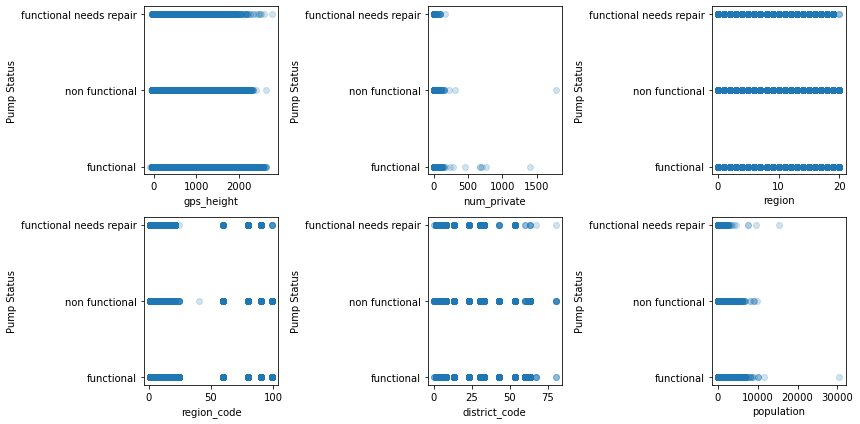

In [14]:
cols = df.select_dtypes('int64', 'float64').columns
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
fig.set_tight_layout(True)
for index, col in enumerate(cols): 
    ax = axes[index//3][index%3]
    ax.scatter(df[col], df.status_group, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("Pump Status")

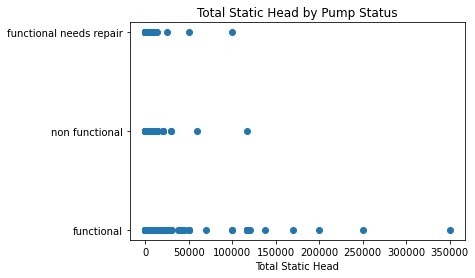

In [15]:
fig, ax = plt.subplots()
ax.scatter(df.amount_tsh, df.status_group)
ax.set_xlabel('Total Static Head')
ax.set_title('Total Static Head by Pump Status');

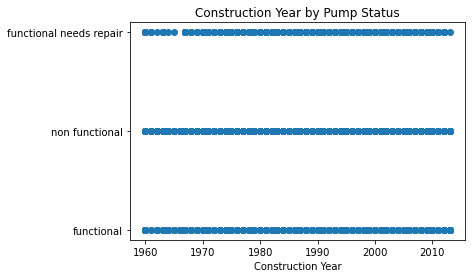

In [16]:
fig, ax = plt.subplots()
ax.scatter(df.construction_year.loc[df.construction_year != 0], 
           df.status_group.loc[df.construction_year !=0])
ax.set_xlabel('Construction Year')
ax.set_title('Construction Year by Pump Status');

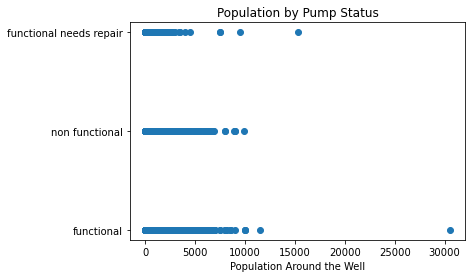

In [17]:
fig, ax = plt.subplots()
ax.scatter(df.population, df.status_group)
ax.set_xlabel('Population Around the Well')
ax.set_title('Population by Pump Status');

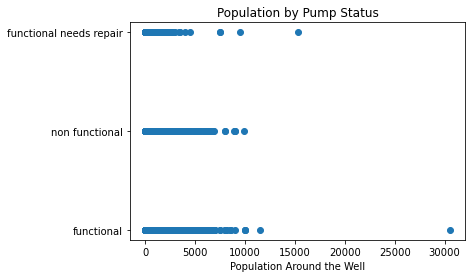

In [18]:
fig, ax = plt.subplots()
ax.scatter(df.population, df.status_group)
ax.set_xlabel('Population Around the Well')
ax.set_title('Population by Pump Status');

### creating a baseline dummy model

In [19]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_model.fit(X_train, y_train);

In [21]:
log_loss_dummy = cross_val_score(dummy_model, X_train, y_train, scoring='neg_log_loss')
log_loss_dummy = -log_loss_dummy.mean()
print('Log Loss:', log_loss_dummy)

Log Loss: 15.78142980024025


### dropping some features we determined that we don't need based on what we've gathered from our EDA

* `amount_tsh` - total static head (amount water available to waterpoint)               **DROP:**  Dataset is missing a majority of values for this feature <br>
* `date_recorded` - the date the row was entered                                        **DROP:** <br>
* `funder` - who funded the well                                                        **DROP:** <br>
* `installer` - organization that installed the well                                    **DROP:** <br>
* `wpt_name` - name of the waterpoint if there is one                                   **DROP:** <br>
* `num_private` -                                                                       **DROP:** <br>
* `subvillage` - geographic location                                                    **DROP:** <br>
* `region_code` - geographic location (coded)                                           **DROP:** 'region' has more information than 'region_code' <br>
* `lga` - geographic location                                                           **DROP:** <br>
* `ward` - geographic location                                                          **DROP:** <br>
* `recorded_by` - group entering this row of data                                       **DROP:** <br>
* `scheme_name` - who operates the waterpoint                                           **DROP:** this feature is duplicative <br>
* `extraction_type_group` - the kind of extraction the waterpoint uses                  **DROP:** <br>
* `extraction_type_class` - the kind of extraction the waterpoint uses                  **DROP:** <br>
* `management_group` - how the waterpoint is managed                                    **DROP:** <br>
* `payment_type` - what the water costs                                                 **DROP:** <br>
* `quality_group` - the quality of the water                                            **DROP:** <br>
* `quantity_group` - the quantity of water                                              **DROP:** <br>
* `source_type` - the source of the water                                               **DROP:** <br>
* `source_class` - the source of the water                                              **DROP:** <br>
* `waterpoint_type_group` - The kind of waterpoint                                      **DROP:** <br>
* `water_quality` - the quality of the water                                            **DROP:** <br>
* `region` - geographic location                                                        **DROP:** <br>
* `waterpoint_type` - the kind of waterpoint                                            **DROP:** <br>
* `source` - the source of the water                                                    **DROP:** <br>

In [22]:
df.drop(columns=['amount_tsh','date_recorded','funder','installer','wpt_name','num_private',
                 'subvillage', 'region_code', 'lga', 'ward', 'recorded_by', 'scheme_name', 
                 'extraction_type_group', 'extraction_type_class', 'management_group', 'payment_type',
                 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group', 'water_quality', 'region', 'waterpoint_type', 'source'], inplace=True)

In [23]:
df.head()

,gps_height,longitude,latitude,basin,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,management,payment,quantity,status_group,water_quality_by_region,water_quality_by_waterpoint_type,water_quality_by_source
id,,,,,,,,,,,,,,,,,,
69572,1390,34.938093,-9.856322,Lake Nyasa,5,109,True,VWC,False,1999,gravity,vwc,pay annually,enough,functional,0,0,0
8776,1399,34.698766,-2.147466,Lake Victoria,2,280,NaN,Other,True,2010,gravity,wug,never pay,insufficient,functional,0,0,0
34310,686,37.460664,-3.821329,Pangani,4,250,True,VWC,True,2009,gravity,vwc,pay per bucket,enough,functional,0,0,0
67743,263,38.486161,-11.155298,Ruvuma / Southern Coast,63,58,True,VWC,True,1986,submersible,vwc,never pay,dry,non functional,0,0,0
19728,0,31.130847,-1.825359,Lake Victoria,1,0,True,NaN,True,0,gravity,other,never pay,seasonal,functional,0,0,0


### creating a hold-out set and running a train_test_split

In [24]:
df, holdout = train_test_split(df, test_size = .1)

In [25]:
X = df.drop('status_group', axis=1)
y = df['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [26]:
X_train.head()

,gps_height,longitude,latitude,basin,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,management,payment,quantity,water_quality_by_region,water_quality_by_waterpoint_type,water_quality_by_source
id,,,,,,,,,,,,,,,,,
52071,1430,38.270243,-4.809781,Pangani,1,1,True,VWC,True,2007,gravity,vwc,never pay,enough,0,0,0
33929,1251,34.145120,-1.367720,Lake Victoria,6,350,True,VWC,True,1992,submersible,vwc,never pay,enough,14,3,2
70140,1109,38.388694,-5.030874,Pangani,2,200,True,VWC,False,1972,gravity,vwc,never pay,dry,0,0,0
34782,0,32.587756,-5.018306,Lake Tanganyika,3,0,True,VWC,True,0,other,vwc,pay monthly,enough,15,1,1
30433,0,32.673419,-2.925467,Lake Victoria,5,0,True,VWC,True,0,nira/tanira,vwc,never pay,dry,7,1,1


In [27]:
X_train.to_csv('data/X_train.csv')
X_test.to_csv('data/X_test.csv')
y_train.to_csv('data/y_train.csv')
y_test.to_csv('data/y_test.csv')
df.to_csv('data/holdout_data.csv')